# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [1]:
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from sklearn import preprocessing

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_max = 256
valor_min = 0
valores_color = 3
num_colores = 100
datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))

## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 7
periodo = 1000
learning_rate = 0.2
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = valores_color
num_datos = num_colores

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario_inicial = int(lado_mapa/2)

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    datos = datos / 255
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random((lado_mapa,lado_mapa,valores_color))

#### Funciones para entrenar/clasificar

In [5]:
# Funcion calcular BMU
def calcular_bmu(patron_entrada, m_pesos):
   # Obtenemos dimensiones de la matriz de pesos para los bucles
   rows = len(m_pesos)
   columns = len(m_pesos[0])
   # Decimos que la ganadora al principio sea la primera neurona
   ganadora = np.linalg.norm(np.array(m_pesos[0][0]) - np.array(patron_entrada))
   Bmu = m_pesos[0][0]
   BmuIndex = np.stack((0,0))
   # Bucle que recorre toda las neuronas
   for x in range(rows):
      for y in range(columns):
         # Obten la distancia euclidea entre la neurona y el patron
         dist = np.linalg.norm(np.array(m_pesos[x][y]) - np.array(patron_entrada))
         # Si la nueva distancia es menor que la ganadora asigna esta neurona como la nueva ganadora
         if dist < ganadora:
            ganadora = dist
            Bmu = m_pesos[x][y]
            BmuIndex = np.stack((x,y))
   return Bmu , BmuIndex



In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   learning_rate = lr_inicial * (1 - i/n_iteraciones)
   return learning_rate


In [7]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   vecindario = 1 + vecindario_inicial * (1 - i/n_iteraciones)
   return vecindario
   

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

In [9]:
#Funcion Ajuste de matriz de pesos
def ajustarPesos(IndexN , color , learning_rate , matriz_pesos , vecindario):
    # Formula para obtener los pesos nuevos de la BMU
    matriz_pesos[IndexN[0]][IndexN[1]] += (learning_rate * (color - matriz_pesos[IndexN[0]][IndexN[1]]))
    # Obtenemos las dimensiones para el bucle
    rows = len(matriz_pesos)
    cols = len(matriz_pesos[0])
    # Bucle que recorre todas la neuronas incluida la BMU
    for x in range(rows):
        for y in range(cols):
            vectorNeurona = [x,y] #Guardamos el indice como un vector
            vectorBMU = [IndexN[0],IndexN[1]] #Guardamos el indice como un vecto
            #Calculamos la discacia euclidea entre ambos vectores para determinar como de lejos estan los indices
            dist_euc = np.linalg.norm(np.array(vectorBMU) - np.array(vectorNeurona)) 
            # Si la distancia es menor o igual que el vecindario y no es 0 (caso de la BMU) entonces sabemos que es vecina de BMU
            if(dist_euc <= vecindario and dist_euc != 0):
              # Dime segun la distancia entre la neuroma vecina y la bmu cuanto es el decay del learning rate
              dist_decay = decay(dist_euc,vecindario)
              # Aplico formula de ajuste de pesos a la neurona vecina segun los datos obtenidos
              matriz_pesos[x][y] += (learning_rate * dist_decay * (color -  matriz_pesos[x][y]))  
            
    return matriz_pesos


#### Funciones para dibujar la salida de la red

In [10]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento

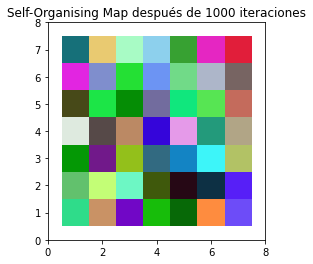

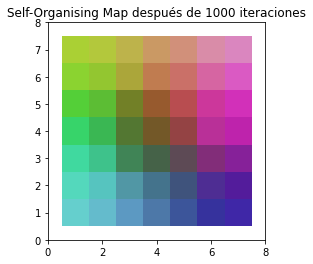

In [11]:
# Entrena la red con el dataset de entrenamiento

# Pintamos mapa de pesos inicial
pintar_mapa(matriz_pesos)
# Reshape de los datos para que se pueda operar con la matriz de pesos
datosT = np.transpose(datos)
# Guardamos las variables iniciales para no modificarlas en las iteraciones de entrenamiento
vecindario = vecindario_inicial
learning_rate_ajustado = learning_rate
for x in range(periodo):
    # Imprime la iteracion actual cada 100 iteraciones
    if(x % 100 == 0 and x != 0):
        print('Iteracion Nº: ',x,end="\r")
    #Obtenemos un indice aleatorio de nuestro set de colores
    numAleatorio = np.random.randint(0, num_colores)
    color = datosT[numAleatorio] 
    #Pasamos el color aleatorio a calcular bmu para que nos devuelva la neurona mas proxima al patron
    Bmu , BmuIndex = calcular_bmu(color,matriz_pesos)
    #Ajustamos la matrix de pesos segun los datos obtenidos
    matriz_pesos = ajustarPesos(BmuIndex , color , learning_rate_ajustado , matriz_pesos , vecindario)
    #Una vez ajustada la matriz de pesos modificamos el learning rate para la siguiente iteracion
    learning_rate_ajustado = variacion_learning_rate(learning_rate, x , periodo)
    #Una vez ajustada la matriz de pesos modificamos el vecindario para la siguiente iteracion
    vecindario = variacion_vecindario(vecindario_inicial , x , periodo)

#Pintamos mapa de pesos final
print('Iteracion Nº: ',x + 1,end="\r")
pintar_mapa(matriz_pesos)

## SOM Clasificación

In [12]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

def Clasificacion(colores , matriz_pesos):

    Mapa_Clasificacion = np.zeros((lado_mapa,lado_mapa,valores_color))
    Mapa_Activacion = np.zeros((lado_mapa,lado_mapa),dtype=int)
    Mapa_Distancias = np.zeros((lado_mapa,lado_mapa))

    clase = 0

    for color in colores:
        bmu , bmuIndex = calcular_bmu(color,matriz_pesos)
        Mapa_Activacion[bmuIndex[0],bmuIndex[1]] += 1 # Cada vez que se activa una neurona (x,y de la ganadora ++)
        # print("Neurona gandora: ", bmuIndex)
        Mapa_Clasificacion[bmuIndex[0],bmuIndex[1]] = color # Se guarda el último color que ha activado la neurona
        # La media de las distancias euclidieas de esa neurona
        Mapa_Distancias[bmuIndex[0],bmuIndex[1]] = (Mapa_Distancias[bmuIndex[0],bmuIndex[1]] + np.linalg.norm(np.array(bmu) - np.array(color))) / 2 
        
    for x in range(len(Mapa_Activacion)):
        for y in range(len(Mapa_Activacion[0])):
            if Mapa_Activacion[x][y] > 0:
                clase += 1

    print("Número de clases: ",clase)
    return Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias

Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias = Clasificacion(np.transpose(datos), matriz_pesos)

"""
print("Mapa activación: \n", Mapa_Activacion)
print("Mapa clasificación: \n", Mapa_Clasificacion)
print("Mapa distancias: \n", Mapa_Distancias)
"""


Número de clases:  41


'\nprint("Mapa activación: \n", Mapa_Activacion)\nprint("Mapa clasificación: \n", Mapa_Clasificacion)\nprint("Mapa distancias: \n", Mapa_Distancias)\n'

## SOM Prueba

In [13]:
# FUnción aux para error topológicos
def calcular_dosbmu(patron_entrada, m_pesos):
   rows = len(m_pesos)
   columns = len(m_pesos[0])
   valores_bmu_pos = {}
   for x in range(rows):
      for y in range(columns):
         dist = np.linalg.norm(np.array(m_pesos[x][y]) - np.array(patron_entrada))
         valores_bmu_pos[dist] = [x,y]
   items = valores_bmu_pos.items()
   valores_ordenados = sorted(items)
   win1 = valores_ordenados[0][1]
   win2 = valores_ordenados[1][1]
   return (0 if np.linalg.norm(np.array(win1)-np.array(win2)) < 2 else 1)

In [14]:
# Clasifica nuevos patrones

colores_prueba = np.random.randint(valor_min, valor_max, (valores_color, num_colores))
colores_prueba = colores_prueba / 255
colores_prueba = np.transpose(colores_prueba)

Mapa_Activacion, Mapa_Clasificacion, Mapa_Distancias = Clasificacion(colores_prueba, matriz_pesos)

# Número de clases
# Error cuantificable
lista_medias = []
for x in range(len(Mapa_Distancias)):
    for y in range(len(Mapa_Distancias)):
        if(Mapa_Distancias[x,y] != 0):
            lista_medias.append(Mapa_Distancias[x,y])
media = sum(lista_medias) / len(lista_medias)
print("Error cuantificable: ",media)
# Error topológico
error_topo = 0
ncolores = 0
for color in np.transpose(datos):
    error_topo += calcular_dosbmu(color,matriz_pesos)
    ncolores += 1
error_topo = error_topo / ncolores
print("Error topológico: ",error_topo*100,"%")

Número de clases:  37
Error cuantificable:  0.1395263054346997
Error topológico:  0.03
